# Importing Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# Import Data

In [2]:
import pandas as pd
data = pd.read_csv('hmnist_28_28_RGB.csv')

In [3]:
y = data['label']
x = data.drop(columns = ['label'])

In [4]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [5]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


# Exploratory Data Analysis (EDA)

# Oversampling
**To overcome class imbalace**

In [6]:
t = np.zeros([46935, 32, 32, 3],dtype=np.float32)
print(t.shape)

(46935, 32, 32, 3)


In [7]:
import scipy.ndimage

In [8]:
for i in range(46935):
    t[i] = scipy.ndimage.zoom(x[i],32/28)

In [9]:
x = np.array(t).reshape(-1,32,32,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 32, 32, 3)


In [10]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

# Model Training

In [11]:
vgg=tf.keras.applications.VGG16(input_shape=(32,32,3),weights='imagenet', include_top=False)
for i in vgg.layers:
    i.trainable = False

In [12]:
model = tf.keras.models.Sequential([
    vgg,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation = 'softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [14]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)


In [15]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 50,
                    epochs = 50,
                    callbacks=[callback])

Epoch 1/50
601/601 [==============================] - ETA: 0s - loss: 1.2877 - accuracy: 0.5300
Epoch 1: saving model to best_model.h5
601/601 [==============================] - 81s 133ms/step - loss: 1.2877 - accuracy: 0.5300 - val_loss: 1.0902 - val_accuracy: 0.6068
Epoch 2/50
601/601 [==============================] - ETA: 0s - loss: 1.0238 - accuracy: 0.6267
Epoch 2: saving model to best_model.h5
601/601 [==============================] - 74s 124ms/step - loss: 1.0238 - accuracy: 0.6267 - val_loss: 0.9753 - val_accuracy: 0.6414
Epoch 3/50
601/601 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.6602
Epoch 3: saving model to best_model.h5
601/601 [==============================] - 73s 121ms/step - loss: 0.9348 - accuracy: 0.6602 - val_loss: 0.9186 - val_accuracy: 0.6618
Epoch 4/50
601/601 [==============================] - ETA: 0s - loss: 0.8810 - accuracy: 0.6828
Epoch 4: saving model to best_model.h5
601/601 [==============================] - 72s 120ms/step 

# Plot Accuracy and Loss

## Accuracy (training vs validation dataset)

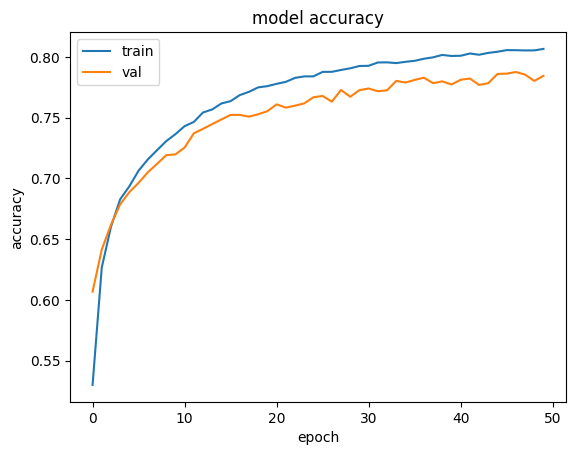

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Loss (training vs validation dataset)

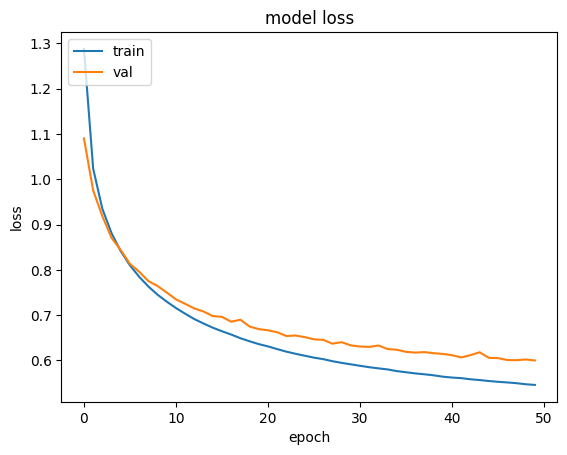

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
model.load_weights('best_model.h5')


# Model Testing

In [29]:
loss, acc = model.evaluate(X_train, Y_train, verbose=2)

1174/1174 - 68s - loss: 0.5522 - accuracy: 0.8048 - 68s/epoch - 58ms/step


In [30]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 17s - loss: 0.5907 - accuracy: 0.7944 - 17s/epoch - 56ms/step


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

In [32]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test) 
y_pred_labels = np.argmax(y_pred_ohe, axis=1) 

confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)

294/294 [==============================] - 18s 61ms/step


In [33]:
class_labels = ['akiec','bcc','bkl','df','nv','vasc','mel']
report = sklearn.metrics.classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

       akiec       0.74      0.86      0.80      1359
         bcc       0.76      0.78      0.77      1318
         bkl       0.72      0.52      0.60      1262
          df       0.93      1.00      0.96      1351
          nv       0.73      0.73      0.73      1374
        vasc       0.98      1.00      0.99      1358
         mel       0.67      0.66      0.66      1365

    accuracy                           0.79      9387
   macro avg       0.79      0.79      0.79      9387
weighted avg       0.79      0.79      0.79      9387



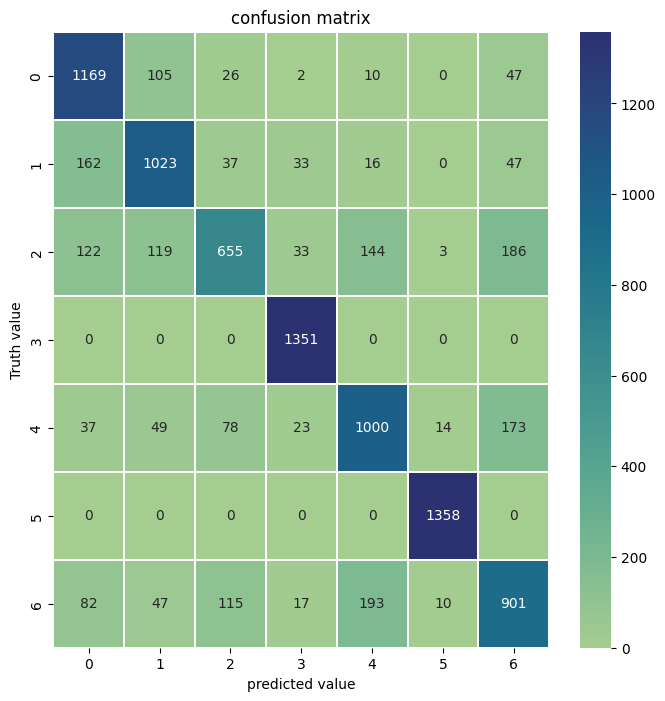

[[1169  105   26    2   10    0   47]
 [ 162 1023   37   33   16    0   47]
 [ 122  119  655   33  144    3  186]
 [   0    0    0 1351    0    0    0]
 [  37   49   78   23 1000   14  173]
 [   0    0    0    0    0 1358    0]
 [  82   47  115   17  193   10  901]]


In [34]:
cm = sklearn.metrics.confusion_matrix(Y_test, y_pred_labels)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(Y_test, y_pred_labels))

c:\python39\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


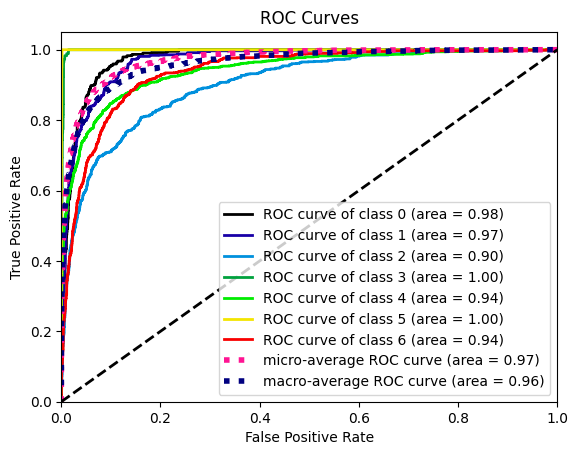

In [43]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve(Y_test, y_pred_ohe)
plt.show()